In [1]:
import imblearn
import numpy as np
import pandas as pd
import pickle
import os
import re
import sklearn

import matplotlib.colors
import matplotlib.pyplot as plt

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from collections import Counter
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

from sklearn import model_selection, naive_bayes, metrics, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from iteration_utilities import deepflatten


from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')

os.chdir('D:\Scraping')

Using TensorFlow backend.


<br></br>
# [1. Assegnazione delle classi](#1)
<br></br>
<font size=3>
    
L'obiettivo di questa prima parte di codice è di assegnare ai pattern relativi un label che sarà il target della classificazione. Per fare ciò si prendono le parole classificate mediante la cluster analysis e i loro sinonimi, parallelamente si uniscono le informazioni del dataset iniziale con i nomi degli attori. 

Per ogni pattern si controlla se le parole al suo interno sono fra i mille termini più frequenti (o nei sinonimi) individuati durante la cluster analysis. Se un termine è individuato, viene assegnata un etichetta e alla fine del pattern si controlla quale sia l'etichetta più frequente togliendo le etichette assegnate alle parole che non sono fra le più frequenti. Il pattern è quindi classificato con l'etichetta più frequente al suo interno, in caso di parità si premia l'etichetta con il termine meno frequente. Nel caso in cui tutte le parole non siano fra le più frequenti, il pattern viene assegnato ad una nuova etichetta. In ogni pattern si controllano se sono presenti i nomi degli attori, sfruttando il fatto che i due dataset hanno stessa lunghezza e si può fare corrispondenza mediante un indice. In caso affermativo viene creata una nuova etichetta per gli attori.
<br></br>
<br></br>
## [1.1 Dataset](#1.1)

<font size=3>
    
I dataset caricati per questo notebook sono:
* `imdb_df4`: era l'ultimo creato nel notebook del pre-processing, al suo interno sono contenute le informazioni sul titolo del film, lo score e le recensioni già divide in frasi.
* `diz_simiarity`: dizionario con i sinonimi ricavati tramite la matrice di similarità con l'approccio su `Wordnet`. Ad ogni parola, elemento chiave, corrisponde una lista si sinonimi, parole che avevano massima similarità con la chiave.
* `w_pattern`: anch'esso ottenuto nel precedente notebook è una lista in cui al suo interno sono presenti i pattern (di parole) significativi identificati nelle frasi delle recensioni.
* `labels_df simlified`: è il file `.csv` con le parole, la loro frequenza e il cluster di appartenenza. È stato modificato per fare in modo che le classi meno numerose siano raggruppate insieme ad altre.
* `imdb_info`: ottenuto nel processo di scraping, contiene le informazioni sui film, la più importante è il nome degli attori.

In [3]:
%%time
# dataframe
with open('imdb_df4', "rb") as input_file:
    imdb_df = pickle.load(input_file)
    
with open("diz_similarity", "rb") as input_file:
    diz_similarity = pickle.load(input_file)
    
with open('w_pattern', "rb") as input_file:
    words = pickle.load(input_file)

labels = pd.read_csv('labels_df simplified.csv', delimiter=";")
info = pd.read_csv("imdb_info.csv", delimiter="\t")

Wall time: 30.9 s


<font size=3>
    
Dal dataset delle etichette si aggiunge la lista di sinonimi alla rispettive parole tramite la funzione `map`.

In [4]:
labels["Synonyms"] = labels["Word"].map(diz_similarity)

labels.head()

,Word,Label,Freq,Synonyms
0,way,0,68935,"[manner, style, fashion, mode]"
1,life,0,61168,[]
2,thing,0,60468,[]
3,love,0,29193,[]
4,problem,0,16458,[]


<font size=3>

Da questo dataset sono creati due dizionari, `diz_cluster` e `diz_freq`: il primo avrà come chiave una delle parole più frequenti e come valore la classe di appartenenza, nel secondo la chiave c'è la stessa chiave e il valore è la frequenza. Questo stesso procedimento è realizzato inseriendo anche i sinonimi dove in questo caso la frequenza è assegnata in base alla parola di riferimento.

In [5]:
diz_cluster = {}
diz_freq = {}
for i in range(len(labels)):
    
    if labels["Word"].iloc[i] not in diz_cluster.keys():
        diz_cluster[labels["Word"].iloc[i]] = labels["Label"].iloc[i]
        diz_freq[labels["Word"].iloc[i]] = labels["Freq"].iloc[i]
    try:  
        if len(labels["Synonyms"].iloc[i]) > 0:
            for word in labels["Synonyms"].iloc[i]:
                if word not in diz_cluster.keys():
                    diz_cluster[word] = labels["Label"].iloc[i]
                    diz_freq[word] = labels["Freq"].iloc[i]
    except TypeError:
        pass

<font size=3>
    
Per il dataset sulle informazioni degli attori è necessario effettuare un pre-processing in quanto salvando delle liste in un dataframe e il tutto come `.csv`, una volta caricati, gli elementi sono sempre considerati come stringhe e non come gli oggetti che erano realmente. Attraverso una regular expression della libreria `re` si ricrea una lista di attori per ogni film utilizzando la virgola come carattere separatore degli elementi e rimuovendo la punteggiatura. I risultati sono inseriti nel dizionario `diz_actor` in cui la chiave è il titolo del film e il valore una lista degli attori protagonisti.

In [6]:
diz_actor = {}
for i in range(len(info)):
    temp = list(info["Actor"].iloc[i].split(","))
    actors = [re.sub(r'[^\w\s]', '', temp[i].strip(" ")) for i in range(len(temp))]
    title = (info["Title"].iloc[i])
    diz_actor[title] = actors

<font size=3>
    
La colonna con i titoli dei film nel dataset delle recensioni viene trasformata in una lista. Sempre attraverso la funzione `map` si assegna ad ogni titolo la lista degli attori protagonisti (la funzione richiede che l'oggetto messo come argomento sia un dizionario).

In [7]:
df_title_list = list(imdb_df["Title"])
new_df = pd.DataFrame({"Title":df_title_list})
new_df["Actors"] = new_df["Title"].map(diz_actor)
new_df

,Title,Actors
0,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
1,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
2,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
3,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
4,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
...,...,...
784254,Il ritorno di Casanova (1992),NaN
784255,Amici per la vita (1992),[]
784256,Amici per la vita (1992),[]
784257,Amici per la vita (1992),[]


<br></br>
## [1.2 Assegnazione](#1.2)

<font size=3>
    
In questo passaggio verraano assegnate le etichette ad ogni pattern rilevante, tenendo presente non solo le informazioni ottenute tramite la cluster analysis, ma anche informazioni esterne ottenute in altri passaggi come il nome degli attori. La prima riga di codice è creare una lista con gli attori presenti in ogni film, ricavato nel passaggio precedente. Questa lista contiene dei duplicati in quanto il riferimento è la singola recensione e non un titolo univoco di film, ma mantenendo questo ordine è possibile far corrispondere questa lista a quella dei pattern rilevanti in quanto la lunghezza dei due oggetti è la stessa, $784259$ elementi, la lunghezza del dataframe originale creato mediante scraping.

In [8]:
actors_list = list(new_df["Actors"])

<font size=3>
    
La seguente funzione di effettuare l'assegnazione. I passaggi sono:
* Creazione di una lista in cui saranno salvate le classi assegnate, `category_list`. Si itera all'interno della lista dei pattern:
    * In ogni elemento è presente una lista con i pattern rilevanti di ogni frase. Sono create delle liste temporanee dove saranno salvate le etichette e delle variabili di controllo, `check` e `max_freq`.
        * Si itera all'interno di ogni lista di pattern rilevanti di frasi in quanto è possibile che una singola frase abbia più pattern rilevanti al suo interno, dunque più elementi e quindi la lista era il formato più comodo per salvare questa informazione. 
        * Se la lunghezza del topic non è nulla, quindi esiste almeno un pattern rilevante per quella frase, si controlla se nella lista degli attori di quel film (ricavabile tramite l'indice della recensione), almeno uno compare nel testo. In caso positivo lo si segnala con una variabile, `actor_value`, altrimenti si procede,
        * Per ogni parola nel pattern rilevanti si controlla quale sia l'eventuale cluster di appartenenza, in caso di assenza fra i termini più comuni si assegna il valore $-1$. Si controlla anche la frequenza delle parole di cui viene presa la minima e la classe di riferimento.
        * Ci crea una lista escludendo i valori negativi delle parole non trovate e si effettua un conteggio delle etichette più frequenti:
            * Se la classe più numerosa è unica e non ci sono attori nel pattern, tutto quel pattern avrà come etichetta quello della classe più comune.
            * Se ci sono più classi con la stessa frequenza si premia quella della parola con la frequenza minore (più rara), in modo da non sfavorire i termini meno comuni.
            * Se è presente almeno un attore nel pattern, il pattern è contrassegnato con una nuova etichetta che rappresenta la classe degli attori.

I risultati sono salvati in una lista per ogni frase e in un'altra lista per ogni recensione. Il risultato finale sarà una lista con tanti elementi quante erano le recensioni originarie e all'interno di ogni elemento una lista con la classe relativa al pattern identificato.

In [52]:
category_list = []
temp = []
for k in tqdm(range(len(words))): # si itera per ogni recensione
    sentence_list = []
    
    for sentence in words[k]: # si itera per ogni frase nella recensione
        temp_list = []
        temp_list2 = []
        check = -1
        max_freq = 1000000
        
        for topic in sentence: # si itera per ogni pattern rilevante nella recensione
            actor_value = 0
            
            # si controlla se la lunghezza è nulla o ci siano nomi di attori
            if len(topic) == 0:
                temp_list2.append('')
                break
            if (type(actors_list[k]) == list) and (len(actors_list[k]) > 0):
                for actor in actors_list[k]:
                    if actor in topic:
                        if len(actor) > 3:
                            temp.append(str(k) + "\t " + actor + "\t "  + topic[0:int(len(topic)/3)])
                            actor_value = 1
                        
            # si itera per ogni parola nel pattern rilevante per identificarne l'appartenenza ad un cluster            
            w = topic.split(" ")
            for word in w:
                category = -1
                if word in diz_cluster.keys():
                    category = diz_cluster[word]
                    freq = diz_freq[word]
                    if freq < max_freq:
                        max_freq = freq
                        check = category
                
                temp_list.append(category)
                
            # si assegna al pattern la classe più frequente nelle sue parole
            temp_list = [el for el in temp_list if el != -1]
            mc = Counter(temp_list).most_common()
            if len(mc) > 0 and actor_value == 0:
                if mc[0][0] != mc[0][1]:
                    temp_list2.append(mc[0][0])
                else:
                    for i in range(len(mc)):
                        if mc[i][0] == check:
                            temp_list2.append(mc[i][0])
                            break
            elif len(mc) == 0 and actor_value == 0:
                temp_list2.append(-1)
            elif actor_value == 1:
                temp_list2.append(100)
        
        sentence_list.append(temp_list2)
    category_list.append(sentence_list)

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:49<00:00, 7176.60it/s]


<font size=3>
    
I pattern con etichetta $-1$ sono stati considerati, rappresentano un nuovo cluster in cui non sono presenti dei termini molto frequenti e saranno la classe degli elementi generali. Sono però rimossi gli elementi nulli, ovvero quelli relativi a quelle frasi dove non è stato riscontrato nessun pattern rilevante, questo viene realizzato sia per le etichette che per le parole.

In [54]:
%%time
test = [el for el in list(deepflatten(category_list, depth=2)) if el != '']
test2 = [el for el in list(deepflatten(words, depth=2)) if el != '']
print(len(test), len(test2))

14149712 14149712
Wall time: 34.2 s


<font size=3>
    
Da queste liste si crea un dataset dove la colonna `Topic` rappresenta il pattern di interesse e la colonna `Label` la classe di riferimento.

In [55]:
pattern_labels = pd.DataFrame({"Topic":test2, "Label":test})
pattern_labels

,Topic,Label
0,Amazing chemistry,4
1,seamless CGI,4
2,practical effects,4
3,film a firecracker script a true,4
4,story pulse pounding soundtrack booming,8
...,...,...
14149707,girl who spent the entire,6
14149708,Everyone around her constantly bent,-1
14149709,little snot,-1
14149710,little brat,-1


In [57]:
with open("pattern_labels", "wb") as output_file:
    pickle.dump(pattern_labels, output_file)

In [2]:
with open("pattern_labels", "rb") as read_file:
    pattern_labels = pickle.load(read_file)

<br></br>
<br></br>
# [2. Modelli di classificazione](#2)

<font size=3>
    
Tramite la funzione `train_test_split` di `sklearn` si ricavano il train e il test del dataset. Nelle variabili il cui nome inizia per "<b>X</b>" sono presenti i pattern di train e di test, nella variabili che iniziano per "<b>y</b>" le etichette di train e di test. Per replicare i risultati e confrontare diveri modelli viene impostato un random seed e la tecnica per scegliere quali osservazioni rientrano nel test o nel train segue l'approccio di stratificazione, ovvero le proporzioni di etichette presenti nel dataset completo si rispecchieranno anche all'interno del train e del test. Non specificando la dimensione del train e del test si applicano i valori di default $70\%$ e $30\%$.

Per applicare una corretta classificazione è necessario trasformare il testo in un oggetto che sia comprensibile ai modelli. La soluzione per cui si è optato è quella del <b>TF-IDF</b> (<i>Term frequency - Inverse document frequency</i>), una metrica che esprime l'importanza di termine in un documento relativamente ad un corpus di documenti. La funzione è composta da due parti: una è la frequenza del termine e l'altra è la frequenza inversa all'interno dei documenti. Lo scopo di questa metrica è premiare le parole frequenti globalmente nel corpus ma presenti in pochi documenti. Esistono diversi metodi per calcolare questa metrica, in `sklearn` la formula utilizzata per il <b>TF-IDF</b> dato un termine $t$ e un documento $d$ è:
$$ TFIDF_{(t,d)} = tf{(t,d)} \times idf{(t)} $$

Dove $tf{(t,d)}$ è il numero di volte che compare il termine $t$ nel documento $d$ e l'altra quantità è pari a: $idf{(t)} = log{\frac{n}{df(t)}}$ con $n$ il numero totale di documenti.

Il primo step è inizializzare questa funzione mediante `TfidfVectorizer` i parametri che riceve in ingresso sono:
* `analyzer`: la tipologia utilizzata per analizzare il testo, in questo caso si seleziona a livello di parola ma è possibile analizzare anche n-grammi.
* `token_pattern`: espressione regolare per definire cosa sia un token. In questo caso a tutte le parole sono rimossi gli elementi di punteggiatura o alfanumerici `\w` di lunghezza pari a uno o superiore `{1,}`.
* `max_features`: il numero di termini da considerare, nel caso ci siano più termini di quelli massimi, si selezionano i più frequenti. Effettuare una analisi con termini rari, anche se si lavoro con una metrica particolare, i risultati possono risentirne in alcuni casi, fissando un limite ragionevole si possono ottenere delle discrete performance.

Il secondo passaggio è quello di centrare/normalizzare i dati togliendo una media comune $\mu$ e dividendo per una variazione $\sigma$. Questi passaggi sono possibili mediante la funzione `fit_transform` che può essere applicata direttamente alla funzione TF-IDF mettendo come input il vettore dei pattern di train. Per i dati di test i valori con cui sono centrati i dati devono essere gli stessi, non si deve riapplicare l'intera funzione ma è sufficiente il metodo `transform`. La funzione `fit_transform` unisce sia la funzione `fit` per salvare i due parametri e `transform` per applicare la trasformazione, richiamando solo il secondo la trasformazione viene realizzata correttamente in quanto i valori sono già stati creati e salvati da `fit_transform` sul train.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(pattern_labels["Topic"], pattern_labels["Label"], 
                                                    stratify = pattern_labels["Label"], random_state = 0)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=20000)
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

<font size=3>
    
Per la matrice di errata classificatione viene definita una nuova scala di colori, totalmente incentrata sul rosso. Come primo passaggio si definisce il range di valori, $[-1,1]$, successivamente una lista di tonalità in corrispondenza di un valore all'interno del range. Con la funzione `LinearSegmentedColormap.from_list` è possibile ridefinire un colore in base ad una lista di valori creati dall'utente. In questo caso si crea un nuovo oggetto che non sostituisce nessuno già esistente ma che presenta la nuova scala di valori.

In [42]:
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "lightyellow"],
          [norm(-0.95), "antiquewhite"],
          [norm(-0.8), "wheat"],
          [norm(-0.3), "navajowhite"],
          [norm( 0.3), "orange"],
          [norm( 0.8), "tomato"],
          [norm( 0.9), "red"],
          [norm( 1.0), "darkred"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

<font size=3>

La funzione `train_model` permette di applicare un metodo di classificazione e di visualizzarne i risultati. I parametri in input sono:
* `classifier`: un metodo di classificatione.
* `feature_vector_train`: un vettore con i dati di train.
* `label`: un vettore con le etichette relative alle osservazioni del train.
* `feature_vector_valid`: un vettore con i dati di test.
* `method`: stringa con il nome del metodo, serve solamente per il print dei risultati.

In questa funzione il classificatore prende in input il vettore dei dati e delle etichette di test e lo si allena con la funzione `fit`. A questo classificatore addestrato viene applicata la funzione `predict` che restituisce come output un vettore di etichette relative al vettore di test dato in input.

Si stampa il report di classificazione comparando il vettore delle etichette di test e il vettore delle etichette prodotto dal modello. Da esso si ricava anche la matrice di confusione.

Per la visualizzazione della matrice si utilizza `matplotlib` per creare l'oggetto e la matrice viene scalata in base ai valori di riga, in modo tale da visualizzare le percentuali e non il numero totale di osservazioni, così facendo la scala di colori definita in precedenza sarà coerente con la proporzione di osservazioni all'interno di ogni cella e non sul numero totale (che non è indicativo delle performance in quanto le classi non sono bilanciate e celle più numerose non corrispondono necessariamente a classificazioni migliori). Si ricava infine il valore di accuratezza che è messo come output della funzione.

In [43]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, method):
    
    # train classification
    classifier.fit(feature_vector_train, label)
    
    # prediction on test
    predictions = classifier.predict(feature_vector_valid)
    
    # report
    print(classification_report(y_test, predictions))
    
    # confusion matrix
    cm = confusion_matrix(predictions, y_test)
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)

    plt.title('Confusion matrix of ' + method, pad=40)
    #ax.set_xticklabels([''] + shortfilename, rotation=45)
    #ax.set_yticklabels([''] + shortfilename)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return metrics.accuracy_score(predictions, y_test)

<br></br>
## [2.1 Naive Bayes](#2.1)

<font size=3>
    
Utilizza il teorema di Bayes per stimare le probabilità di appartenenza di un'osservazione ad una determinata classe; è uno dei metodi più utilizzati nella classificazione di testi ed è spesso utilizzato con dei dati rappresentati da un vettore TF-IDF. Per ogni classe $y$ il modello crea un vettore $\theta_y = (\theta_{y1}, \theta_{y2}, \dots, \theta_{yn})$ in cui ogni singolo elemento rappresenta la probabilità $P(x_i|y)$ di appartenenza di quel termine alla classe $y$; il vettore ha lunghezza $n$ come il numero di termini dati in input.

I valori di probabilità sono stimati mediante una funzione di massima verosimiglianza incentrata sulle frequenze:

$$ \hat{\theta}_{yi} = \frac{N_{yi} + \alpha}{N_y + \alpha n}$$

Dove $N_{yi} = \sum_{x \in T}{x_i}$ è il numero di volte che un termine compare in un campione della classe $y$ nel training set $T$ e $N_y = \sum_{i=1}^{n}{N_{yi}}$ è il numero totale di termini nella classe $y$.

Il valore $\alpha$ è chiamato fattore di smoothing e di default è pari a $1$; serve per gestire i casi in cui nel test set si trovino dei termini non presenti nel train evitando problemi di calcolo o l'assegnazione diretta di probabilità nulle.

<br></br>
<br></br>
# [3. GridSearch](#3)

<font size=3>
    
La funzione `GridSearchCV` permette di realizzare diverse prove su un modello di classificazione e trovare il migliore al variare dei parametri. Il modello migliore viene selezionato in base ad una metrica scelt in input dall'utente.

Il modello selezionato per la <b>GridSearch</b> è il Naive Bayes: anche se è quello con le peggiori performance, è anche il più veloce da allenare e permette quindi di realizzare molte più combinazioni rispetto agli altri modelli. La speranza è che miglioramenti significativi possano rispecchiarsi anche negli altri modelli.

I parametri da ricercare sono:
* `alpha`: con diversi valori, da un minimo di $1^{-10}$, estremo inferiore per l'algoritmo e un massimo di uno.
* `fit_prior`: se il modello deve o meno considerare le probabilità a priori, se è il parametro è falso viene applicata una probabilità a priori uniforme.

In [16]:
model = naive_bayes.MultinomialNB()
parameters = {"alpha":[1e-10, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1], 
              "fit_prior":[True, False]}

<font size=3>
    
La ricerca effettua tutte le combinazioni possibili dei parametri dati in input precedentemente: nel caso in esame ci sono $8$ parametri per il valore di $\alpha$ e $2$ per le probabilità a priori per un totale di $8*2=16$ modelli differenti. Gli altri parametri della funzione sono:
* `cv`: è il numero di fold di cross-validazione che la funzione applica per rendere i risultati più robusti. Con questo parametro attivo la funzione effettua un ulteriore split sul train in due dataset, valuta attraverso la CV la metrica di ogni fold e ne restituisce la media. Il valore impostato è $3$, ciò significa che il totale di operazioni effettuate dall'algoritmo sarà $16*3=48$.
* `verbose`: un valore numerico, più è alto, più informazioni sono stampate a schermo durante il processo di creazione dei modelli.
* `n_jobs`: il numero di core da utilizzare dato che l'algoritmo supporta processi in parallelo. Più è alto più core e CPU sarà utilizzata e più velocemente il processo di ricerca terminerà (i tempi non scalano linearmente con il variare dei core selezionati).

La ricerca dei modelli è effettuata dopo la creazione del vettore <b>TF-IDF</b>. L'output della ricerca è il modello migliore sul train che poi viene addestrato sui dati di test. È possibile poi ricavare come prima il livello di accuratezza e i parametri che definiscono il modello migliore.

In [62]:
clf = GridSearchCV(model, param_grid=parameters, scoring="accuracy", cv=3, verbose=10, n_jobs=5)
clf.fit(xtrain_tfidf, y_train)
y_pred = clf.predict(xtest_tfidf)
print(clf.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   13.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   18.6s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   27.4s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   37.3s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   48.1s remaining:    4.3s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   52.2s finished


{'alpha': 1e-10, 'fit_prior': True}


In [63]:
accuracy_score(y_test, y_pred)

0.5522419113548035

<br></br>
## [3.1 Features](#3.1)

<font size=3>

La qualità dei modelli ricercati dipende molto anche dai dati che vengono forniti in input, ovvero di come vengono creati i valori di <b>TF-IDF</b>. La funzione `grid` combina diversi parametri per la creazione dei vettori di features, i parametri in input sono:
* `features`: il numero di features massime che il modello deve considerare. Nell'esempio in precedenza sono state considerate $20000$ features, questo parametro riceve in input una lista di valori e per ognuno di essi ricava le features più appropriate e su di esse si effettua una ricerca dei modelli migliori.
* `model`: il modello in input, in questo caso sempre il Naive Bayes.
* `parameters`: anche questo come il precedente è un parametro per la <b>GridSearch</b>.
* `analyzer`: la metodologia con la quale le features devono essere considerate, in questi casi parole e non singoli caratteri.
* `stop`: se applicare o meno un filtro di stopwords.
* `ngram_range`: se considerare gli n-grammi nel processo di creazione delle features. Il valore in input a questo parametro è una tupla dove l'estremo inferiore rappresenta la lunghezza minima degli oggetti e l'estremo superiore la lunghezza massima. Il valore $1$ per entrambi gli estremi indica solamente le parole normali, la combinazione $(2,2)$ indica solo bigrammi, la combinazione $(1,2)$ indica si parole singole che bigrammi contemporaneamente. A seconda di come è impostato questo parametro, il numero di features massime da considerare dovrà adattarsi di conseguenza.
* `verbose`: per visualizzare il progresso.

In breve la funzione combina la ricerca delle features con la ricerca dei modelli migliori. Per ogni valore di features il modello migliore è salvato in una lista.

In [4]:
def grid(features, model, parameters, analyzer, stop, ngram_range=(1,1), verbose=10):
    score_list = []
    for feature in features:
        tfidf_vect = TfidfVectorizer(analyzer=analyzer, token_pattern=r'\w{1,}', max_features=feature, 
                                     stop_words=stop, ngram_range=ngram_range)
        xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
        xtest_tfidf =  tfidf_vect.transform(X_test)

        clf = GridSearchCV(model, param_grid=parameters, scoring="accuracy", cv=3, verbose=verbose, n_jobs=5)
        clf.fit(xtrain_tfidf, y_train)
        y_pred = clf.predict(xtest_tfidf)
        score_list.append(clf.best_params_)
        score_list.append(accuracy_score(y_test, y_pred))
    
    return (score_list)

<font size=3>
    
Questa funzione mostra a schermo i risultati della ricerca. Per ogni valore di feature si è trovato il modello migliore, la funzione mostra i parametri del modello e il livello di accuratezza raggiunto.

In [5]:
def score(score_list):
    i = 0
    while i < len(score_list):
        print("Parametri: " + str(score_list[i]) + "\tAccuratezza: " + str(round(score_list[i+1], 4)))
        i += 2

<font size=3>
    
I parametri in ingresso per la griglia sono gli stessi, le features partono da un minimo molto basso di $1000$ per poi crescere progressivamente fino ad arrivare a tutte le features possibili senza limiti massimi.

In [66]:
features = [1000, 3000, 5000, 10000, 15000, 20000, 50000, None]

model = naive_bayes.MultinomialNB()

parameters = {"alpha":[1e-10, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1], 
              "fit_prior":[True, False]}
    
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None, verbose=0)

<font size=3>
    
Un esempio di output dei risultati è il seguente: il modello migliore per $1000$ features ha un $\alpha$ sostanzialmente nullo e utilizza le probabilità a priori, raggiungendo un livello di accuratezza di $0.5089$. Per ogni riga si ha il modello migliore per ogni valore di features.

In [67]:
score(score_list)

Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5089
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5474
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5515
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5524
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5522
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5522
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5504
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5547


<br></br>
## [3.2 Rimozione stopwords con TfidfVectorizer](#3.2)

<font size=3>
    
Nelle analisi precedenti non è stato assegnato nessun parametro a `stop`, dunque tutte le parole erano state prese in considerazione per la creazione del vettore di features. Una scelta più saggia è quella di escludere questi termini non indicativi in quanto possono avere dei valori di <b>TF-IDF</b> molto importanti nella logica dell'algoritmo per effettuare la classificazione.
<br></br>

Il parametro fa riferimento proprio alla creazione del vettore di features e specificando la stringa `english` è possibile filtrare le stopwords inglesi, la rimozione è già implementata nella funzione senza dover specificare una lista esterna, ma bisogna specificare la stringa poiché il parametro di default è nullo (come visto in precedenza).
<br></br>

Tutti gli altri parametri del modello e della ricerca sono lasciati invariati ad eccezione del numero di features poiché numero molto bassi non portavano a buoni risultati.

In [69]:
features = [5000, 10000, 15000, 20000, 50000]

model = naive_bayes.MultinomialNB()

parameters = {"alpha":[1e-10, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1], 
              "fit_prior":[True, False]}
    
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop="english", verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   44.3s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   45.1s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   44.7s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   45.3s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   47.1s finished


<font size=3>
    
Dai risultati riportati in seguito si nota come non c'è un grande miglioramento nell'accuratezza, e i migliori modelli hanno pressoché le stesse performance.

In [70]:
score(score_list)

Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5529
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5541
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5541
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5537
Parametri: {'alpha': 0.2, 'fit_prior': True}	Accuratezza: 0.5516


<br></br>
## [3.3 Rimozione stopwords con NLTK](#3.3)

<font size=3>
    
La lista di stopwords utilizzate nel pacchetto sklearn, ricavabile con `sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS` non è necessariamente uguale a quella di `nltk`, inizializzata durante l'import delle librerie all'inizio del notebook con `stop = set(stopwords.words("english"))`. 
<br></br>

Si verifica se l'utilizzo di un diverso set di stopwords può migliorare le performance. A differenza del metodo precedente, qua la rimozione deve essere effettuata prima delle creazione del dataset. Quando si selezionano i pattern rilevanti, scartando quelli vuoti, si filtrano anche le stopwords.

In [71]:
%%time
test = [el for el in list(deepflatten(category_list, depth=2)) if el != '']
test2 = [el for el in list(deepflatten(words, depth=2)) if el != '']

Wall time: 37.3 s


<font size=3>
    
La funzione sw_rem prende in input una lista di termini e ad uno ad uno controlla che non siano presenti nella lista delle stopword. Si ricrea una stringa per ogni pattern inserendo le parole adeguate seguite da uno spazio; quando questa stringa viene aggiunta alla lista in output, l'ultimo spazio bianco viene rimosso.

In [7]:
def sw_rem(word_list):
    new_test = []
    for pattern in word_list:
        new_pattern = ""
        pattern = pattern.split(" ")
        for word in pattern:
            if word not in stop:
                new_pattern = new_pattern + word + " "
        new_test.append(new_pattern[:-1])
    
    return(new_test)

<font size=3>
    
La lista senza stopword diventa la nuova colonna del dataset.

In [73]:
new_test = sw_rem(test2)
print(len(test), len(new_test))

pattern_labels = pd.DataFrame({"Topic":new_test, "Label":test})

14149712 14149712


<font size=3>
    
Di conseguenza si deve ricavare un nuovo split.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(pattern_labels["Topic"], pattern_labels["Label"], 
                                                    stratify = pattern_labels["Label"], random_state = 0)

In [76]:
features = [5000, 10000, 15000, 20000, 50000]
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   45.2s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   44.9s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   45.8s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   45.7s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   47.8s finished


In [77]:
score(score_list)

Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5647
Parametri: {'alpha': 0.1, 'fit_prior': True}	Accuratezza: 0.5652
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5649
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5643
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5619


<br></br>
## [3.4 Rimozione stopwords mista](#3.4)

<font size=3>
    
Avendo confermato che le due liste di stopwords sono differenti, si prova una classificazione con entrambe.

In [78]:
features = [5000, 10000, 15000, 20000, 50000]

score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop="english")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   16.2s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   26.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   36.1s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   47.4s remaining:    4.2s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   51.4s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   11.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   16.4s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   27.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   37.4s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   48.5s remaining:    4.3s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   52.5s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   15.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   24.9s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   33.7s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   43.4s remaining:    3.9s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   46.9s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   15.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   24.5s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   34.1s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   44.2s remaining:    3.9s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   47.8s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   14.8s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   23.9s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   33.2s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   43.1s remaining:    3.8s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   47.0s finished


In [79]:
score(score_list)

Parametri: {'alpha': 0.1, 'fit_prior': True}	Accuratezza: 0.5535
Parametri: {'alpha': 0.1, 'fit_prior': True}	Accuratezza: 0.5545
Parametri: {'alpha': 0.1, 'fit_prior': True}	Accuratezza: 0.5546
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5543
Parametri: {'alpha': 0.2, 'fit_prior': True}	Accuratezza: 0.5522


<br></br>
## [3.5 Bigrammi](#3.5)

<font size=3>
    
Una tecnica che dovrebbe effettivamente migliorare le performance del modello è quella di considerare n-grammi. La rappresentazione di una parola affiancata ad un'altra può essere molto più informativa delle due parole singole. Come primo step si parte con il considerare solamente i bigrammi, senza le parole singole. Da qui in poi sarà applicata la rimozione delle stopwords in quanto più sensata e leggermente migliore in termini di risultati.

In [80]:
features = [15000, 20000, 50000, 100000, None]
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None,
                 ngram_range=(2,2), verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   39.5s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   40.0s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   42.7s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   45.4s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.9min finished


<font size=3>
    
Sicuramente i risultati sono scadenti perché la dimensione della lista di features non era adeguata alla numerosità di bigrammi che si sono creati e quindi un gran numero è stato scartato. Come si nota di seguito i livelli di accuratezza sono molto distanti da quelli precedenti, però è anche vero che senza scartare nessun elemento i risultati sono sempre abbastanza mediocri. Questo lascia pensare che indipendentemente dal numero di features considerate, una classificazione con solamente i bigrammi e ignorando le parole singole non è utile.

In [81]:
score(score_list)

Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.3687
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.3798
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.4152
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.4401
Parametri: {'alpha': 0.1, 'fit_prior': True}	Accuratezza: 0.4779


<br></br>
## [3.6 Unigrammi e bigrammi](#3.6)

<font size=3>
    
Il passo successivo è quello di considerare sia le parole singole che i bigrammi. L'unione delle informazioni della frequenza dei singoli termini e la combinazione con altre parole dovrebbe dare delle informazioni extra e dunque migliorare il modello con solo le singole parole. In questo caso è stato adeguato il numero di feature da valutare.

In [82]:
features = [150000, 200000, 350000, 550000, None]
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None,
                 ngram_range=(1,2), verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   58.6s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.1min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  2.2min finished


In [83]:
score(score_list)

Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5927
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5932
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5936
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.593
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.5816


<font size=3>
    
Dall'output si nota come il miglioramento è evidente: il passaggio da $0.552$ a $0.594$ è in termini assoluti limitato, però considerando che si tratta del modello peggiore, questa soluzione lascia ben sperare per l'applicazione su modelli più performanti. Il numero di features è stato scelto in modo coerente: sia $15000$ che oltre il doppio ottengono gli stessi risultati, mentre senza nessuna limitazione i risultati peggiorano ma sono comunque migliori di qualsiasi altra tecnica provata fino a questo momento.

<br></br>
## [3.7 Da unigrammi a trigrammi](#3.7)

<font size=3>
    
Andando aventi ulteriormente è possibile aggiungere anche i trigrammi. Non dovrebbero avere un grosso impatto in quanto molti pattern hanno lunghezza contenuta ed alcuni sono formati da due singole parole, però si prova comunque a fare un tentativi. Il numero di features è scalato in proporzione al numero di elementi attesi che saranno individuati. Non viene valutato il modello senza limitazioni in quanto le informazioni non possono essere contenute in solo $32$ GB di memoria.

In [63]:
features = [500000, 1000000, 2000000, 2500000]
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop="english",
                  ngram_range=(1,3), verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    8.4s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   14.7s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   21.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   33.1s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   45.1s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   58.5s remaining:    5.2s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.1min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   14.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   21.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   34.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   47.5s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:  1.0min remaining:    5.5s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.1min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   15.8s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   23.4s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   38.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   52.9s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:  1.1min remaining:    6.1s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    8.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   16.6s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   24.4s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   39.5s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   54.5s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:  1.2min remaining:    6.4s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.3min finished


<font size=3>
    
Non si nota un ulteriore miglioramento. Il modello migliore è quello con più termini ma aggiungerne altri non è possibile per motivi di memoria.

In [64]:
score(score_list)

Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5723
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5693
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5762
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5774


<br></br>
## [3.8 Unione con w2v](#3.8)

<font size=3>
    
Per questo lavoro è possibile percorrere un'altra strada che è quella di far riferimento ai termini più simili per ciascuna parola più frequente individuandoli tramite il modello w2v addestrato su tutte le recensioni. Questo modello era stato creato per la cluster analisi, da cui si ricavava una matrice di similarità e sulla quale sono state realizzate le tecniche di clustering agglomerativo. Il modello tuttavia non presentava risultati incoraggianti e l'indice si Silhouette era distante dal migliore ottenuto tramite i synset delle tassonomie.
<br></br>

Il modello viene caricato dovendo specificare anche la classe callback che era stata create nell'altro notebook per visualizzare la funzione di perdita ad ogni iterazione dato che di default la libreria forniva la perdita totale del modello ad una certa epoca e non la differenza fra un epoca e l'altra. Per un bug di gensim non è possibile caricare il modello che ha salvato queste informazioni aggiuntive ed una delle soluzione è richiamare la funzione create e poi successivamente caricare il modello.

In [84]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [85]:
model_w2v = Word2Vec.load("IMDB_word2vec.model")

<font size=3>
    
Dato che l'assegnazione dei label ai diversi pattern è stata effettuata considerando i termini più frequenti e i sinonimi identificati dal synset di WordNet, tutto il dataset deve essere ricaricato e la lista dei sinonimi deve essere estesa con i nuovi termini trovati dal modello w2v.

In [103]:
labels = pd.read_csv('labels_df simplified.csv', delimiter=";")
labels["Synonyms"] = labels["Word"].map(diz_similarity)

<font size=3>

La funzione w2v_most_similar ha il compito di creare una lista dei termini più comuni ad ogni termine più frequente secondo il modello w2v generato e alla cosine similarity. L'unico parametro in ingresso è il numero di termini da considerare in quanto saranno realizzate diverse prove raccogliendo un certo numero di parole più simili. Sinteticamente i passaggi della funzione sono:
* Si scorre per ogni parola del dataset (termini più frequenti) e si trovano i top termini più simili. Il risultato è una lista al cui interno ogni elemento è una tupla con parola e valore di cosine similarity.
* Per ogni parola in questa lista si controlla se non sia già nel dataset (la metrica di similarità varia dai synset al modello w2v, è quindi possibile che un termine presente in questi sia in realtà già un valore del dataset) e nemmeno nei sinonimi di quella parola.
* Se questa parola è nuova viene aggiunta al dizionario insieme alla parola corrispondente e in un altro dizionario anche il valore di similarità. Se la parola invece esiste già nel dizionario si controlla se la similarità è maggiore di quella già salvata.
    * In caso affermativo, il dizionario viene aggiornato con la nuova chiave.
    * In caso negativo, la parola non è aggiunta la dizionario.
    
L'output della funzione è un dizionario in cui le chiavi sono i termini nel dataset e i valori una lista di termini più comuni ritrovati.

In [6]:
def w2v_most_similar(topn):
    w2v_diz_sim = {}
    diz_max = {}
    diz_ok = {}
    for i in range(len(labels)):
        temp = []
        try:
            sim = model_w2v.most_similar(labels["Word"].iloc[i], topn=topn)
            for j in range(len(sim)):
                if sim[j][0].lower() != labels["Word"].iloc[i] and sim[j][0] not in labels["Synonyms"].iloc[i] and "_" not in sim[j][0]:
                    if sim[j][0].lower() not in diz_ok.keys():
                        diz_max[sim[j][0].lower()] = labels["Word"].iloc[i]
                        diz_ok[sim[j][0].lower()] = sim[j][1]
                        temp.append(sim[j][0].lower())
                    else:
                        if diz_ok[sim[j][0].lower()] < sim[j][1]:
                            diz_ok[sim[j][0].lower()] = sim[j][1]
                            diz_max[sim[j][0].lower()] = labels["Word"].iloc[i]
                            temp.append(sim[j][0].lower())
                        else:
                            pass
        except KeyError:
            pass
        w2v_diz_sim[labels["Word"].iloc[i]] = temp
        
    return (w2v_diz_sim, diz_max)

<font size=3>
    
Come primo modello si seleziona il numero di elementi di default, $10$.

In [105]:
(w2v_diz_sim, diz_max) = w2v_most_similar(topn=10)

<font size=3>
    
Nella funzione w2v_most_similar sono stati creati due dizionari per gestire i casi in cui una parola risultasse molto simile a più termini diversi. Il rischio è che questa parola possa essere associata a due termini che però nella clusterizzazione appartengono a due gruppi differenti. La seguente funzione quindi rimuove tutti i duplicati tenendo solamente il termine riferito alla parola con la similarità migliore.
<br></br>

Ad esempio la parola <i>year</i> non era presente nel dataset ma è stata trovata dal modello w2v più di una volta e quindi assegnata a più parole. La seguente funzione controlla nei due dizionari creati in precedenza a quali parole è collegata e quali sono i valori di similarità tenendo solo il collegamento con la cosine similarity più alta.

In [106]:
for key in w2v_diz_sim.keys():
    new_l = []
    for word in w2v_diz_sim[key]:
        try:
            if diz_max[word] == key:
                new_l.append(word)
            else:
                pass
        except KeyError:
            pass
    w2v_diz_sim[key] = new_l

<font size=3>
    
Visualizzazione del nuovo dataset con la lista di sinonimi che si è allargata.

In [107]:
for i in range(len(labels)):
    labels["Synonyms"].iloc[i] = labels["Synonyms"].iloc[i] + list(w2v_diz_sim.values())[i]
labels.head()

,Word,Label,Freq,Synonyms
0,way,0,68935,"[manner, style, fashion, mode, ways, hurry, pr..."
1,life,0,61168,[existence]
2,thing,0,60468,"[what, things, stuff]"
3,love,0,29193,"[loved, loves, hate, loving]"
4,problem,0,16458,"[issue, problems]"


<font size=3>
    
A questo punto con il nuovo dataset di devono riassegnare tutte le etichette con tutti gli step relativi. Per evitare di riproporre tutto il codice, le parti del notebook della prima parte sono stati salvati in un file .py che è richiamato di seguito. La funzione cluster_label condensa tutti gli step e restituisce il dataset con pattern e classe. I parametri sono:
* w2v: se è zero viene caricato il dataset da zero, in questo caso è già stato fatto. La funzione sarà richiamata in seguito in altre applicazioni dove non è necessario utilizzare il modello w2v, in quei casi sarà necessario richiamare il dataset da zero.
* stopw: se è uno, si applica già un filtraggio delle stopwords.

In [108]:
%run -i "labels.py"
(w2v_labels, test2) = cluster_label(w2v=1, stopw=1)

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:40<00:00, 7802.15it/s]


In [109]:
w2v_labels

,Topic,Label
0,Amazing chemistry,4
1,seamless CGI,4
2,practical effects,4
3,film a firecracker script a true,4
4,story pulse pounding soundtrack booming,4
...,...,...
14149707,girl who spent the entire,6
14149708,Everyone around her constantly bent,50
14149709,little snot,50
14149710,little brat,50


<font size=3>
    
Si applica la funzione sw_rem per rimovere le stopword e creare sostituire la nuova lista nel dataset.

In [110]:
new_test = sw_rem(test2)
w2v_labels["Topic"] = new_test

In [112]:
X_train, X_test, y_train, y_test = train_test_split(w2v_labels["Topic"], w2v_labels["Label"], 
                                                    stratify = w2v_labels["Label"], random_state = 0)

### [3.8.1 Unigrammi e stopwords](#3.8.1)

<font size=3>
    
Si inizia con una prova sulle singole parole.

In [116]:
features = [10000, 15000, 20000, 50000, None]

model = naive_bayes.MultinomialNB()

parameters = {"alpha":[1e-10, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1], 
              "fit_prior":[True, False]}
    
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   45.7s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   44.4s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   47.8s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   46.9s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   50.6s finished


<font size=3>
    
I risultati sono buoni, ma sempre leggermente inferiori a quelli ottenuti in precedenza.

In [117]:
score(score_list)

Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5403
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5413
Parametri: {'alpha': 0.8, 'fit_prior': True}	Accuratezza: 0.5404
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5363
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5365


### [3.8.2 Unigrammi e bigrammi](#3.8.2)

In [119]:
features = [150000, 200000, 350000, 550000, None]
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None,
                  ngram_range=(1,2), verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   57.5s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   59.0s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.0min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.1min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  2.0min finished


<font size=3>
    
Anche con l'unione di unigrammi e bigrammi non si migliorano le performance.

In [120]:
score(score_list)

Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5592
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5597
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5556
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5604
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.5555


### [3.8.3 Unigrammi con numero variabile di termini simili](#3.8.3)

<font size=3>
    
Le scarse performance possono essere dettate dal numero di termini che sono presi in considerazione come candidati sinonimi. Il seguente blocco di codice replica le analisi precedenti iterando su una lista che definisce il numero di parole da considerare nel modello w2v:
* Per ogni numero massimo di parole si carica il dataset di base.
* Si applica il modello w2v per trovare un numero massimo di sinonimi, si rimuovono i duplicati e si crea un nuovo dataset senza le stopwords.
* Si divide il dataset in train e test e successivamente si itera per il numero di features per creare diversi modelli.

In [148]:
top_words = [1, 2, 5, 20]
features = [10000, 15000, 20000, 50000, None]

for top in top_words:
    labels = pd.read_csv('labels_df simplified.csv', delimiter=";")
    labels["Synonyms"] = labels["Word"].map(diz_similarity)
    
    (w2v_diz_sim, diz_max) = w2v_most_similar(topn=top)
    
    # rimozione duplicati
    for key in w2v_diz_sim.keys():
        new_l = []
        for word in w2v_diz_sim[key]:
            try:
                if diz_max[word] == key:
                    new_l.append(word)
                else:
                    pass
            except KeyError:
                pass
        w2v_diz_sim[key] = new_l
        
    # creazione df
    for i in range(len(labels)):
        labels["Synonyms"].iloc[i] = labels["Synonyms"].iloc[i] + list(w2v_diz_sim.values())[i]
        
    # assegnazione etichette
    (w2v_labels, test2) = cluster_label(w2v=1, stopw=1)
    new_test = sw_rem(test2)
    w2v_labels["Topic"] = new_test
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(w2v_labels["Topic"], w2v_labels["Label"], 
                                                    stratify = w2v_labels["Label"], random_state = 0)
    
    # modelli
    score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None, verbose=0)
    
    print("Classificazione con " + str(top) + " termini più simili:")
    score(score_list)
    print("\n")

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:43<00:00, 7572.54it/s]


Classificazione con 1 termini più simili:
Parametri: {'alpha': 1, 'fit_prior': True}	Accuratezza: 0.5786
Parametri: {'alpha': 1, 'fit_prior': True}	Accuratezza: 0.5784
Parametri: {'alpha': 1, 'fit_prior': True}	Accuratezza: 0.5779
Parametri: {'alpha': 1, 'fit_prior': True}	Accuratezza: 0.5752
Parametri: {'alpha': 0.1, 'fit_prior': True}	Accuratezza: 0.5704




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:34<00:00, 8316.21it/s]


Classificazione con 2 termini più simili:
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5474
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5473
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5469
Parametri: {'alpha': 0.05, 'fit_prior': True}	Accuratezza: 0.5438
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5516




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:38<00:00, 8002.37it/s]


Classificazione con 5 termini più simili:
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5452
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5461
Parametri: {'alpha': 1, 'fit_prior': True}	Accuratezza: 0.5456
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5423
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5435




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:41<00:00, 7696.24it/s]


Classificazione con 20 termini più simili:
Parametri: {'alpha': 0.2, 'fit_prior': True}	Accuratezza: 0.5349
Parametri: {'alpha': 0.2, 'fit_prior': True}	Accuratezza: 0.5358
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5348
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5305
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.528




<font size=3>
    
Dai risultati di accuracy sembrerebbe che più termini sono presi in considerazione, più le performance del modello calino. Questo potrebbe essere dato dal fatto che queste parole, anche se non così frequenti alcune volte, non sono discriminatorie fra le diverse classi e quindi invece di aiutare il modello, lo mettono in difficoltà.

### [3.8.4 Unigrammi e bigrammi con numero variabile di termini simili](#3.8.4)

<font size=3>
    
Si replicano le analisi considerando unigrammi e bigrammi.

In [149]:
top_words = [1, 2, 5, 20]
features = [150000, 200000, 350000, 550000, None]

for top in top_words:
    labels = pd.read_csv('labels_df simplified.csv', delimiter=";")
    labels["Synonyms"] = labels["Word"].map(diz_similarity)
    
    (w2v_diz_sim, diz_max) = w2v_most_similar(topn=top)
    
    # rimozione duplicati
    for key in w2v_diz_sim.keys():
        new_l = []
        for word in w2v_diz_sim[key]:
            try:
                if diz_max[word] == key:
                    new_l.append(word)
                else:
                    pass
            except KeyError:
                pass
        w2v_diz_sim[key] = new_l
        
    # creazione df
    for i in range(len(labels)):
        labels["Synonyms"].iloc[i] = labels["Synonyms"].iloc[i] + list(w2v_diz_sim.values())[i]
        
    # assegnazione etichette
    (w2v_labels, test2) = cluster_label(w2v=1, stopw=1)
    new_test = sw_rem(test2)
    w2v_labels["Topic"] = new_test
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(w2v_labels["Topic"], w2v_labels["Label"], 
                                                    stratify = w2v_labels["Label"], random_state = 0)
    
    # modelli
    score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None, 
                      ngram_range=(1,2), verbose=0)
    
    print("Classificazione con " + str(top) + " termini più simili:")
    score(score_list)
    print("\n")

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:30<00:00, 8653.54it/s]


Classificazione con 1 termini più simili:
Parametri: {'alpha': 0.8, 'fit_prior': True}	Accuratezza: 0.591
Parametri: {'alpha': 0.8, 'fit_prior': True}	Accuratezza: 0.5911
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5907
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5897
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.577




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [02:00<00:00, 6494.88it/s]


Classificazione con 2 termini più simili:
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5767
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5775
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.578
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5747
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.5691




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:54<00:00, 6850.39it/s]


Classificazione con 5 termini più simili:
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5663
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5668
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5623
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.567
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.5597




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [02:05<00:00, 6262.50it/s]


Classificazione con 20 termini più simili:
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5548
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5555
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5562
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5548
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.5535




<font size=3>
    
Anche in questo caso più parole significano meno accuratezza. Con una sola parola aggiunta le performance sono sempre intorno allo $0.59$ ma con decimali più bassi.

### [3.8.5 Unigrammi e bigrammi e livello soglia di similarità](#3.8.5)

<font size=3>
    
Un'alternativa è quella di non considerare un numero fisso di parole poiché a seconda del termine selezionato i primi termini più simili potrebbero avere valori di similarità molto diversi. La funzione w2v_most_similar2 ricava i $100$ termini più simili per ogni parola, ma considera possibili candidati solamente quelli che hanno una similarità superiore ad una certa soglia. Il resto della funzione lavora nello stesso modo di quella precedente.

In [128]:
def w2v_most_similar2(sim_value, topn=100):
    w2v_diz_sim = {}
    diz_max = {}
    diz_ok = {}
    for i in range(len(labels)):
        temp = []
        try:
            sim = model_w2v.most_similar(labels["Word"].iloc[i], topn=topn)
            for j in range(len(sim)):
                if sim[j][1] > sim_value:
                    if sim[j][0].lower() != labels["Word"].iloc[i] and sim[j][0] not in labels["Synonyms"].iloc[i] and "_" not in sim[j][0]:
                        if sim[j][0].lower() not in diz_ok.keys():
                            diz_max[sim[j][0].lower()] = labels["Word"].iloc[i]
                            diz_ok[sim[j][0].lower()] = sim[j][1]
                            temp.append(sim[j][0].lower())
                        else:
                            if diz_ok[sim[j][0].lower()] < sim[j][1]:
                                diz_ok[sim[j][0].lower()] = sim[j][1]
                                diz_max[sim[j][0].lower()] = labels["Word"].iloc[i]
                                temp.append(sim[j][0].lower())
                            else:
                                pass
        except KeyError:
            pass
        w2v_diz_sim[labels["Word"].iloc[i]] = temp
        
    return (w2v_diz_sim, diz_max)

<font size=3>
    
Prima di iterare sulla lista di valori si effettuano delle prove per vedere il numero di sinonimi totali che sarebbero individuati dal modello w2v data una certa soglia. Dall'output della funzione i valori del dizionario sono messi in una lista e successivamente si estraggono con set gli elementi unici.

In [141]:
test_sim_value = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sin_words = []
for value in test_sim_value:
    (w2v_diz_sim, diz_max) = w2v_most_similar2(sim_value=value)
    sin_words.append(len(set(list(deepflatten(list(w2v_diz_sim.values()), depth=1)))))
                     
test_sim_value_df = pd.DataFrame({"Sim value":test_sim_value, "Num words":sin_words})
test_sim_value_df.head(len(test_sim_value))

,Sim value,Num words
0,0.4,7163
1,0.5,3478
2,0.6,961
3,0.7,162
4,0.8,24
5,0.9,0


<font size=3>
    
Come realizzato prima per il numero di parole da considerare, il seguente blocco di codice effettua una doppia iterazione, sia su una lista di valori minimi di similarità necessari per considerare una parola un sinonimo e sul numero di features. In base ai risultati ottenuti in precedenza si selezionano i valori intermedi con l'aggiunta di $0.65$ che potrebbe portare ad un buon trade-off.

In [147]:
test_sim_value = [0.6, 0.65, 0.7, 0.8]
features = [150000, 200000, 350000, 550000, None]

for value in test_sim_value:
    labels = pd.read_csv('labels_df simplified.csv', delimiter=";")
    labels["Synonyms"] = labels["Word"].map(diz_similarity)
    
    (w2v_diz_sim, diz_max) = w2v_most_similar2(sim_value=value)
    
    # rimozione duplicati
    for key in w2v_diz_sim.keys():
        new_l = []
        for word in w2v_diz_sim[key]:
            try:
                if diz_max[word] == key:
                    new_l.append(word)
                else:
                    pass
            except KeyError:
                pass
        w2v_diz_sim[key] = new_l
        
    # creazione df
    for i in range(len(labels)):
        labels["Synonyms"].iloc[i] = labels["Synonyms"].iloc[i] + list(w2v_diz_sim.values())[i]
        
    # assegnazione etichette
    (w2v_labels, test2) = cluster_label(w2v=1, stopw=1)
    new_test = sw_rem(test2)
    w2v_labels["Topic"] = new_test
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(w2v_labels["Topic"], w2v_labels["Label"], 
                                                    stratify = w2v_labels["Label"], random_state = 0)
    
    # modelli
    score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None, 
                      ngram_range=(1,2), verbose=0)
    
    print("Classificazione con " + str(value) + " similarità di soglia:")
    score(score_list)
    print("\n")

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:32<00:00, 8474.91it/s]


Classificazione con 0.6 similarità di soglia:
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5725
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5732
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.569
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.574
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.5664




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:58<00:00, 6642.22it/s]


Classificazione con 0.65 similarità di soglia:
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5771
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5777
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5783
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.575
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.5687




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:43<00:00, 7546.82it/s]


Classificazione con 0.7 similarità di soglia:
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5848
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5853
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5858
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5853
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.575




100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:49<00:00, 7155.09it/s]


Classificazione con 0.8 similarità di soglia:
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5908
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5914
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5918
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5912
Parametri: {'alpha': 0.5, 'fit_prior': False}	Accuratezza: 0.58




<font size=3>
    
Anche in questo caso si conferma quello detto in precedenza: più termini non aiutano il modello e man mano che la soglia di similarità aumenta, più salgono le performance.

<br></br>
## [3.9 Ricampionamento](#3.9)

<font size=3>
    
Una soluzione molto utilizzata per risolvere i problemi di classi non bilanciate è quella di ricampionare le osservazioni. Queste tecniche si dividono principalmente in oversampling, ovvero ricampionare le osservazioni dalle classi meno numerose e undersampling che ha l'approccio opposto. Anche se il comando "stratify" durante lo split fra train e test aiuta a mantenere la stessa proporzione di osservazioni nelle diverse classi fra i due dataset, ed è proprio una alternativa al ricampionamento, si possono ottenere comunque risultati interessanti.
<br></br>

All'interno di queste due macrocategorie esistono diverse tecniche specifiche, ognuna con una sua particolarità.

### [3.9.1 Random oversampling](#3.9.1)

<font size=3>
    
La prima tecnica è quella di ricampionare le osservazioni delle classi meno frequenti in modo casuale. Questo metodo non dovrebbe ottenere delle buone performance in quanto è noto in letteratura che si tende ad avere overfitting.

In [2]:
with open("pattern_labels", "rb") as read_file:
    pattern_labels = pickle.load(read_file)

In [8]:
new_test = sw_rem(pattern_labels["Topic"])

pattern_labels["Topic"] = new_test

<font size=3>
    
Questione molto importante è il momento in cui bisogna effettuare il ricampionamento. Come riportato da [diverse analisi](https://beckernick.github.io/oversampling-modeling/) il ricampionamento deve essere effettuato dopo la divisione fra train e test in modo da evitare che delle osservazioni identiche possano finire in entrambi i dataset.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(pattern_labels["Topic"], pattern_labels["Label"], 
                                                    stratify = pattern_labels["Label"], random_state = 0)

<font size=3>
    
La funzione grid2 è una variazione della precedente in cui non è compreso lo split del dataset e la creazione dei vettori TF-IDF in quanto questa procedura varia a seconda della strategia di ricampionamento utilizzata. La funzione contiene solamente gli step finali che partono dalla ricerca dei modelli fino al salvataggio dei risultati di accuratezza.

In [10]:
def grid2(xtrain_tfidf, y_train, model, parameters, verbose):
    clf = GridSearchCV(model, param_grid=parameters, scoring="accuracy", cv=3, verbose=verbose, n_jobs=5)
    clf.fit(xtrain_tfidf, y_train)
    y_pred = clf.predict(xtest_tfidf)
    score_list.append(clf.best_params_)
    score_list.append(accuracy_score(y_test, y_pred))
    
    return (score_list)

<font size=3>
    
L'installazione della libreria imblearn, deve essere fatta attraverso i privilegi di amministrazione e installerà anche una nuova versione di sklear.utilities.
Richiamare la libreria potrebbe chiamare problemi con sklearn per l'import di alcuni moduli, la [soluzione](https://stackoverflow.com/questions/56540967/sklearn-model-selection-error-importerror-cannot-import-name-approximate-mod) è quella di riavviare il kernel.
<br></br>
   
Per l'oversampling casuale è necessario creare un oggetto omonimo alla sua libreria, RandomOverSampler, e selezionare un random seed per replicare i risultati, non sono necessari altri parametri. Applicando la funzione fit_sample a questo oggetto, si creano i vettori di TF-IDF. Da qui in poi saranno utilizzati solamente modelli con unigrammi e bigrammi.

In [153]:
from imblearn.over_sampling import RandomOverSampler

score_list = []
features = [150000, 200000, 350000, 550000, None]
for feature in features:
    tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=feature, 
                                 stop_words=None, ngram_range=(1,2))
    xtrain_tfidf = tfidf_vect.fit_transform(X_train)
    xtest_tfidf = tfidf_vect.transform(X_test)
    
    ros = RandomOverSampler(random_state=0)
    ros_xtrain_tfidf, ros_y_train = ros.fit_sample(xtrain_tfidf, y_train)
    
    score_list = grid2(model=model, xtrain_tfidf=ros_xtrain_tfidf, y_train=ros_y_train, parameters=parameters, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  2.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  2.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  2.3min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  2.3min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  4.0min finished


<font size=3>
    
Non si hanno i valori di accuratezza sul train ma quelli sul test indicano che questa tecnica non è adatta al dataset.

In [154]:
score(score_list)

Parametri: {'alpha': 1e-10, 'fit_prior': False}	Accuratezza: 0.5543
Parametri: {'alpha': 1e-10, 'fit_prior': False}	Accuratezza: 0.5535
Parametri: {'alpha': 1e-10, 'fit_prior': False}	Accuratezza: 0.5504
Parametri: {'alpha': 1e-10, 'fit_prior': False}	Accuratezza: 0.5458
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5035


### [3.9.2 Random undersampling](#3.9.2)

In [156]:
from imblearn.under_sampling import RandomUnderSampler
score_list = []
features = [30000, 50000, 100000, 150000, 200000, None]
for feature in features:
    tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=feature, 
                                 stop_words=None, ngram_range=(1,2))
    xtrain_tfidf = tfidf_vect.fit_transform(X_train)
    xtest_tfidf = tfidf_vect.transform(X_test)

    rus = RandomUnderSampler(random_state=0, replacement=True)
    rus_xtrain_tfidf, rus_y_train = rus.fit_sample(xtrain_tfidf, y_train)
    
    score_list = grid2(model=model, xtrain_tfidf=rus_xtrain_tfidf, y_train=rus_y_train, parameters=parameters, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:    9.4s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:    8.9s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   10.0s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   10.4s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   11.2s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   55.2s finished


In [157]:
score(score_list)

Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5457
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5442
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5424
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5413
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5401
Parametri: {'alpha': 0.8, 'fit_prior': False}	Accuratezza: 0.5164


<font size=3>
    
Le prossime tecniche si basano tutte sulla ricerca di osservazioni chiave che dovranno essere ricampionate, poiché più informative di altre. La selezione di queste viene realizzata tramite una Nearest Neighbour che può richiedere diverso tempo e anche la creazione dei vettori TF-IDF con molte più informazioni rallenta notevolamente i processi.
<br></br>

Sono state realizzate delle prove con un campione ridotto del dataset e i tempi computazionali crescono in maniera quasi esponenziale all'aumentare delle osservazioni e non è possibile effettuare questi ricampionamenti su tutte le classi. Una alternativa è quindi quella di analizzare i risultati del migliore modello fino ad adesso e vedere se nelle statistiche del report c'è una classe in cui il modello fatica particolarmente.

In [56]:
tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=350000, stop_words=None, 
                             ngram_range=(1,2))
xtrain_tfidf = tfidf_vect.fit_transform(X_train)
xtest_tfidf = tfidf_vect.transform(X_test)

              precision    recall  f1-score   support

          -1       0.56      0.86      0.68    720508
           0       0.60      0.46      0.52    343136
           4       0.64      0.46      0.53    331548
           6       0.59      0.49      0.54    369540
           8       0.63      0.45      0.53    296363
           9       0.57      0.29      0.39    100668
          10       0.60      0.64      0.62    881921
          50       0.62      0.49      0.55    416871
         100       0.59      0.71      0.64     76873

    accuracy                           0.59   3537428
   macro avg       0.60      0.54      0.56   3537428
weighted avg       0.60      0.59      0.58   3537428

[[622682  62431  54839  68669  52402  21071 135947  72378  12739]
 [  5454 156228  15132  15255  13243   4281  33197  16452    632]
 [  3538  12845 151658  11752  10685   3269  29976  13857    760]
 [ 10672  17678  16979 182058  13671   7276  36656  21599   2706]
 [  4522  11252  10281   8994 1

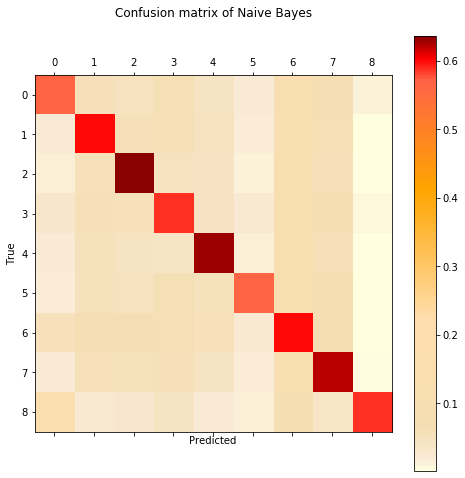

NB, WordLevel TF-IDF:  0.5936013397304483
Wall time: 12.3 s


In [57]:
%%time
accuracy = train_model(naive_bayes.MultinomialNB(alpha=0.3, fit_prior=True), xtrain_tfidf, y_train, xtest_tfidf, 
                       "Naive Bayes")
print ("NB, WordLevel TF-IDF: ", accuracy)

<font size=3>
    
Anche se la classe degli attori, l'ultima, è quella meno numerosa, le performance sono accettabili e non le peggiori. La classe numero $9$ ha bassa precisione e bassa recall ed è la candiata per il ricampionamento. Come si evince però da tutti i livelli di precisione, non ci sono delle classi in cui il modello è particolarmente funzionante, ma sono tutte su livelli simili, questo può segnalare che un miglioramento radicale delle performance non sia possibile.

In [12]:
class_freq = dict(Counter(y_test).most_common())
class_freq

{10: 881921,
 -1: 720508,
 50: 416871,
 6: 369540,
 0: 343136,
 4: 331548,
 8: 296363,
 9: 100668,
 100: 76873}

<font size=3>
    
Dalle classi del test di estraggono le numerosità.

### [3.9.3 SMOTE oversampling](#3.9.3)

In [77]:
from imblearn.over_sampling import SMOTE

score_list = []
features = [100000, 150000, 200000, 350000, 550000]
for feature in features:
    tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=feature, 
                                 stop_words=None, ngram_range=(1,2))
    xtrain_tfidf = tfidf_vect.fit_transform(X_train)
    xtest_tfidf = tfidf_vect.transform(X_test)

    sm = SMOTE(random_state=0, sampling_strategy={9:class_freq[10]})
    sm_xtrain_tfidf, sm_y_train = sm.fit_sample(xtrain_tfidf, y_train)
    
    score_list = grid2(model=model, xtrain_tfidf=sm_xtrain_tfidf, y_train=sm_y_train, parameters=parameters, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.0min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.0min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.3min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.4min finished


In [78]:
score(score_list)

Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5928
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5938
Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5943
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5943
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5936


In [17]:
from imblearn.over_sampling import SMOTE

score_list = []
features = [200000, 350000]
for feature in features:
    tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=feature, 
                                 stop_words=None, ngram_range=(1,2))
    xtrain_tfidf = tfidf_vect.fit_transform(X_train)
    xtest_tfidf = tfidf_vect.transform(X_test)

    sm = SMOTE(random_state=0, k_neighbors=10, sampling_strategy={9:class_freq[10]})
    sm_xtrain_tfidf, sm_y_train = sm.fit_sample(xtrain_tfidf, y_train)
    
    score_list = grid2(model=model, xtrain_tfidf=sm_xtrain_tfidf, y_train=sm_y_train, parameters=parameters, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.4min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.4min finished


In [18]:
score(score_list)

Parametri: {'alpha': 0.5, 'fit_prior': True}	Accuratezza: 0.5944
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5943


### [3.9.4 ADASYN oversampling](#3.9.4)

In [ ]:
from imblearn.over_sampling import ADASYN

score_list = []
features = [200000, 350000]
for feature in features:
    tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=feature, 
                                 stop_words=None, ngram_range=(1,2))
    xtrain_tfidf = tfidf_vect.fit_transform(X_train)
    xtest_tfidf = tfidf_vect.transform(X_test)

    ad = ADASYN(random_state=0, sampling_strategy={9:class_freq[10]}, n_jobs=5)
    ad_xtrain_tfidf, ad_y_train = ad.fit_sample(xtrain_tfidf, y_train)
    
    score_list = grid2(model=model, xtrain_tfidf=ad_xtrain_tfidf, y_train=ad_y_train, parameters=parameters, verbose=1)

In [ ]:
score(score_list)

### [3.9.6 NearMiss undersampling](#3.9.6)

In [41]:
%%time
from imblearn.under_sampling import NearMiss

score_list = []
features = [100000, 150000, 200000, 350000, 550000]
for feature in features:
    tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=feature, 
                                 stop_words=None, ngram_range=(1,2))
    xtrain_tfidf = tfidf_vect.fit_transform(X_train)
    xtest_tfidf = tfidf_vect.transform(X_test)

    nm = NearMiss(version=1)
    nm_xtrain_tfidf, nm_y_train = nm.fit_sample(xtrain_tfidf, y_train)
    
    score_list = grid2(model=model, xtrain_tfidf=nm_xtrain_tfidf, y_train=nm_y_train, parameters=parameters, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:    0.9s finished


KeyboardInterrupt: 

In [ ]:
score(score_list)

In [ ]:
score_list = []
features = [100000, 150000, 200000, 350000, 550000]
for feature in features:
    tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=feature, 
                                 stop_words=None, ngram_range=(1,2))
    xtrain_tfidf = tfidf_vect.fit_transform(X_train)
    xtest_tfidf = tfidf_vect.transform(X_test)

    nm = NearMiss(version=2)
    nm_xtrain_tfidf, nm_y_train = nm.fit_sample(xtrain_tfidf, y_train)
    
    score_list = grid2(model=model, xtrain_tfidf=nm_xtrain_tfidf, y_train=nm_y_train, parameters=parameters, verbose=1)

In [ ]:
score(score_list)

In [ ]:
score_list = []
features = [100000, 150000, 200000, 350000, 550000]
for feature in features:
    tfidf_vect = TfidfVectorizer(analyzer="word", token_pattern=r'\w{1,}', max_features=feature, 
                                 stop_words=None, ngram_range=(1,2))
    xtrain_tfidf = tfidf_vect.fit_transform(X_train)
    xtest_tfidf = tfidf_vect.transform(X_test)

    nm = NearMiss(version=3)
    nm_xtrain_tfidf, nm_y_train = nm.fit_sample(xtrain_tfidf, y_train)
    
    score_list = grid2(model=model, xtrain_tfidf=nm_xtrain_tfidf, y_train=nm_y_train, parameters=parameters, verbose=1)

In [ ]:
score(score_list)

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
model = LogisticRegression()
parameters = {"C":[0.01, 0.1, 1, 10, 50], 
              "solver":["newton-cg", "lbfgs"]}

In [57]:
def grid(features, model, parameters, analyzer, stop, ngram_range=(1,1), verbose=10):
    score_list = []
    for feature in features:
        tfidf_vect = TfidfVectorizer(analyzer=analyzer, token_pattern=r'\w{1,}', max_features=feature, 
                                     stop_words=stop, ngram_range=ngram_range)
        xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
        xtest_tfidf =  tfidf_vect.transform(X_test)

        clf = GridSearchCV(model, param_grid=parameters, scoring="accuracy", cv=3, verbose=verbose, n_jobs=5)
        clf.fit(xtrain_tfidf, y_train)
        y_pred = clf.predict(xtest_tfidf)
        score_list.append(clf.best_params_)
        score_list.append(accuracy_score(y_test, y_pred))
    
    return (score_list)

In [58]:
features = [200000, 350000]
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop=None, verbose=1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 1089.1min finished


KeyboardInterrupt: 

<br></br>
## [3.10 Alternative a TF-IDF](#3.10)

In [23]:
from textvec import vectorizers
from textvec.vectorizers import (TfBinIcfVectorizer, Tfchi2Vectorizer, TfgrVectorizer, 
                                 TfIcfVectorizer, TfigVectorizer, TforVectorizer, TfpfVectorizer, 
                                 TfrfVectorizer, TfrrfVectorizer, SifVectorizer)

In [24]:
with open("pattern_labels", "rb") as read_file:
    pattern_labels = pickle.load(read_file)
    
new_test = sw_rem(pattern_labels["Topic"])
pattern_labels["Topic"] = new_test

X_train, X_test, y_train, y_test = train_test_split(pattern_labels["Topic"], pattern_labels["Label"], 
                                                    stratify = pattern_labels["Label"], random_state = 0)

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

score_list = []
features = [200000, 350000]

for feature in features:
    cv = CountVectorizer()
    cv_train = cv.fit_transform(X_train)
    cv_test = cv.transform(X_test)
    
    tfgr_vect = vectorizers.TfIcfVectorizer(norm="l2")
    xtrain_tfgr = tfgr_vect.fit_transform(cv_train, y_train)
    xtest_tfgr = tfgr_vect.transform(cv_test)
    
    clf = GridSearchCV(model, param_grid=parameters, scoring="accuracy", cv=3, verbose=verbose, n_jobs=5)
    clf.fit(xtrain_tfgr, y_train)
    y_pred = clf.predict(xtest_tfgr)
    score_list.append(clf.best_params_)
    score_list.append(accuracy_score(y_test, y_pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
def grid3(features, model, parameters, analyzer, stop, ngram_range=(1,1), vectorizer, verbose=10):
    score_list = []
    for feature in features:
        tfidf_vect = TfidfVectorizer(analyzer=analyzer, token_pattern=r'\w{1,}', max_features=feature, 
                                     stop_words=stop, ngram_range=ngram_range)
        xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
        xtest_tfidf =  tfidf_vect.transform(X_test)

        clf = GridSearchCV(model, param_grid=parameters, scoring="accuracy", cv=3, verbose=verbose, n_jobs=5)
        clf.fit(xtrain_tfidf, y_train)
        y_pred = clf.predict(xtest_tfidf)
        score_list.append(clf.best_params_)
        score_list.append(accuracy_score(y_test, y_pred))
    
    return (score_list)

<br></br>
## [3.5 Unione classi nomi attori e attori](#3.5)

In [41]:
temp_label = list(pattern_labels["Label"])
new_label = []
for el in temp_label:
    if el == 100:
        el = 6
    new_label.append(el)
    
pattern_labels["Label"] = new_label

In [42]:
X_train, X_test, y_train, y_test = train_test_split(pattern_labels["Topic"], pattern_labels["Label"], 
                                                    stratify = pattern_labels["Label"], random_state = 0)

In [43]:
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop="english")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    8.9s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   13.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   21.5s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   29.7s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   38.3s remaining:    3.4s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   41.8s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    9.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   13.7s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   22.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   30.8s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   39.8s remaining:    3.5s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   43.2s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    8.8s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   13.6s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   30.3s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   39.5s remaining:    3.5s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   42.8s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   13.4s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   30.4s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   39.4s remaining:    3.5s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   43.0s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   14.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   23.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   32.9s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   42.5s remaining:    3.8s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   46.1s finished


In [44]:
i = 0
while i < len(score_list):
    print("Parametri: " + str(score_list[i]) + "\tAccuratezza: " + str(round(score_list[i+1], 4)))
    i += 2

Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5515
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5484
Parametri: {'alpha': 0.8, 'fit_prior': True}	Accuratezza: 0.548
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5477
Parametri: {'alpha': 0.3, 'fit_prior': True}	Accuratezza: 0.5454


<br></br>
## [3.6 Label originali](#3.6)

In [56]:
original_labels = cluster_label()

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:31<00:00, 8540.19it/s]


In [59]:
X_train, X_test, y_train, y_test = train_test_split(original_labels["Topic"], original_labels["Label"], 
                                                    stratify = original_labels["Label"], random_state = 0)

In [60]:
features = [1000, 3000, 5000, 10000, 15000, 20000, 50000, None]
score_list = grid(features=features, model=model, parameters=parameters, analyzer="word", stop="english")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   12.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   28.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   38.5s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   49.7s remaining:    4.4s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   53.8s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   16.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   26.5s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   36.9s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   47.5s remaining:    4.2s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   51.7s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   11.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   16.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   27.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   37.3s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   48.7s remaining:    4.3s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   53.3s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   16.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   26.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   36.8s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   47.8s remaining:    4.3s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   52.1s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   16.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   27.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   37.5s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   48.2s remaining:    4.3s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   52.6s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   16.8s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   27.1s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   37.7s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   48.7s remaining:    4.3s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   53.2s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   12.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   30.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   41.5s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   53.8s remaining:    4.8s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:   58.1s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   12.5s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   30.8s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   43.1s
[Parallel(n_jobs=5)]: Done  44 out of  48 | elapsed:   56.0s remaining:    5.0s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.0min finished


In [61]:
i = 0
while i < len(score_list):
    print("Parametri: " + str(score_list[i]) + "\tAccuratezza: " + str(round(score_list[i+1], 4)))
    i += 2

Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.4955
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5289
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5317
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5325
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5325
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5323
Parametri: {'alpha': 1e-10, 'fit_prior': True}	Accuratezza: 0.5308
Parametri: {'alpha': 1, 'fit_prior': False}	Accuratezza: 0.5208
